# Sentiment Analysis (CV-TF_IDF-HASH) 

### Import necessary libraries

In [320]:
# Dataframe
import pandas as pd

# Array
import numpy as np
import itertools

# Decompress the file
import gzip

# Visualizations
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import matplotlib.colors as colors
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS

# Datetime
from datetime import datetime

# text preprocessing
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize.toktok import ToktokTokenizer
import gensim
import re


import unicodedata
tokenizer = ToktokTokenizer()
nlp = spacy.load('en', parse=True, tag=True, entity=True)

## Modeling
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from catboost import CatBoostClassifier, Pool
from sklearn.naive_bayes import GaussianNB 
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from  sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from gensim.models import Word2Vec
from tqdm import tqdm
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier

## Warnings
import warnings
from scipy import stats
warnings.filterwarnings('ignore')

In [321]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier

### Reading the Cleaned Dataset

In [322]:
# Read the file
df3 = pd.read_csv('/users/hp/desktop/Ds-springboard/capstone_2/data/Reduced_Cleaned_Reviews_electronics_headphones.csv')



In [323]:
# Sample observations
df3.head(3)

,product_id,rating,reviewer_id,reviewer_name,unix_review_time,url,description,categories,product_title,price,...,pos_feedback,neg_feedback,rating_class,help_prop,clean_text,year,rating_class_num,token,review_length,review_length_bin
0,B004PYD88I,5,A2814AB4U75Q2L,AlohaKona,2013-03-26,http://ecx.images-amazon.com/images/I/512ENRj4...,VIZIO's Bluetooth Stereo Headphones feature hi...,"[['Electronics', 'Accessories & Supplies', 'Au...",VIZIO XVTHB100 Bluetooth Stereo Headphones (Bl...,1.73,...,0,0,good,0.0,vizio bluetooth stereo headphones please headp...,2013,1,"['vizio', 'bluetooth', 'stereo', 'headphones',...",32,"(0.0, 100.0]"
1,B004PYD88I,3,A1D0V9EVJQMXIK,Amazon Customer,2013-02-25,http://ecx.images-amazon.com/images/I/512ENRj4...,VIZIO's Bluetooth Stereo Headphones feature hi...,"[['Electronics', 'Accessories & Supplies', 'Au...",VIZIO XVTHB100 Bluetooth Stereo Headphones (Bl...,1.73,...,1,0,good,1.0,agree good headphone pair iphone easily sound ...,2013,1,"['agree', 'good', 'headphone', 'pair', 'iphone...",114,"(100.0, 200.0]"
2,B004PYD88I,2,A2KA0B8FP32CHH,"Chesteracorgi ""Chesteracorgi""",2011-08-22,http://ecx.images-amazon.com/images/I/512ENRj4...,VIZIO's Bluetooth Stereo Headphones feature hi...,"[['Electronics', 'Accessories & Supplies', 'Au...",VIZIO XVTHB100 Bluetooth Stereo Headphones (Bl...,1.73,...,0,1,bad,0.0,uncomfortable tinny sound buy read review try ...,2011,0,"['uncomfortable', 'tinny', 'sound', 'buy', 're...",96,"(0.0, 100.0]"


In [324]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 23 columns):
product_id           15000 non-null object
rating               15000 non-null int64
reviewer_id          15000 non-null object
reviewer_name        15000 non-null object
unix_review_time     15000 non-null object
url                  15000 non-null object
description          10013 non-null object
categories           15000 non-null object
product_title        15000 non-null object
price                15000 non-null float64
related              15000 non-null object
brand_name           15000 non-null object
review_text          15000 non-null object
pos_feedback         15000 non-null int64
neg_feedback         15000 non-null int64
rating_class         15000 non-null object
help_prop            15000 non-null float64
clean_text           15000 non-null object
year                 15000 non-null int64
rating_class_num     15000 non-null int64
token                15000 non-nul

In [325]:
# Drop unnecessary columns
df4 = df3.drop(['rating','reviewer_name','unix_review_time','url','description','categories','product_title','price','related','brand_name','pos_feedback', 'neg_feedback','help_prop','rating_class_num','review_length','review_length_bin'], axis=1)



In [326]:
df4.head()

,product_id,reviewer_id,review_text,rating_class,clean_text,year,token
0,B004PYD88I,A2814AB4U75Q2L,Vizio Bluetooth Stereo Headphones I am very pl...,good,vizio bluetooth stereo headphones please headp...,2013,"['vizio', 'bluetooth', 'stereo', 'headphones',..."
1,B004PYD88I,A1D0V9EVJQMXIK,I have to agree The Good: These headphone pair...,good,agree good headphone pair iphone easily sound ...,2013,"['agree', 'good', 'headphone', 'pair', 'iphone..."
2,B004PYD88I,A2KA0B8FP32CHH,Uncomfortable and tinny sound I bought these o...,bad,uncomfortable tinny sound buy read review try ...,2011,"['uncomfortable', 'tinny', 'sound', 'buy', 're..."
3,B004PYD88I,A3K2Y8JBW9X1EJ,The Most Uncomfortable Headphones These headph...,bad,uncomfortable headphones headphones look moder...,2012,"['uncomfortable', 'headphones', 'headphones', ..."
4,B004PYD88I,A3PCEB9ND82AGE,sounds good but bad fit. Two stars knocked off...,good,sound good bad fit two star knock must use nar...,2013,"['sound', 'good', 'bad', 'fit', 'two', 'star',..."


In [327]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 7 columns):
product_id      15000 non-null object
reviewer_id     15000 non-null object
review_text     15000 non-null object
rating_class    15000 non-null object
clean_text      15000 non-null object
year            15000 non-null int64
token           15000 non-null object
dtypes: int64(1), object(6)
memory usage: 820.4+ KB


# Natural Language Processing

## 1. Feature Engineering and Selection

Machine Learning models take numerical values as input. Our dataset is a list of sentences, so in order for our algorithm to extract patterns from the data, we first need to find a way to represent it in a way that our algorithm can understand, i.e. as a list of numbers.

We will implement CounterVectorizer, TF-IDF, Hash Vectorizer, Word2Vec, adding most common words into the stopwords list, SMOTE, PCA, and Truncated SVD techniques into our models in the following sections as a part of feature engineering and selection.

## 2. Data Preprocessing

### Separating Response Variable and Feature

In [328]:
df4['rating_class'] = df4['rating_class'].apply(lambda x: 0 if x == 'bad' else 1)

In [329]:
# Splitting the Data Set into Train and Test Sets
X = df4['clean_text']
y = df4['rating_class']

### Splitting Dataset into Train and Test Set

We split our data in to a training set used to fit our model and a test set to see how well it generalizes to unseen data.

In [330]:
# Splitting Dataset into train and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [331]:
# Print train and test set shape
print ('Train Set Shape\t\t:{}\nTest Set Shape\t\t:{}'.format(X_train.shape, X_test.shape))

Train Set Shape		:(11250,)
Test Set Shape		:(3750,)


## 3. Selecting the Right Evaluation Metric

Since the data is imbalanced, the evaluation of the classifier performance must be carried out using adequate metrics in order to take into account the class distribution and to pay more attention to the minority class. When the positive class is smaller and the ability to detect correctly positive samples is our main focus (correct detection of negatives examples is less important to the problem) we should use precision and recall. For our particular case, based on this thought I will use f1 score which is harmonic average of precision and recall as my evaluation metric.

### Confusion Matrix Plot Function

Understanding the types of errors our model makes, and least desirable are important . A good way to visualize that information is using a Confusion Matrix, which compares the predictions our model makes with the true label. With that in mind, we used confusion matrix besides our evaluation metric (f1 score).

In [332]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.ocean):
    """
    Create a confusion matrix plot for 'good' and 'bad' rating values 
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title, fontsize = 20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize = 20)
    plt.yticks(tick_marks, classes, fontsize = 20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment = "center", 
                 color = "white" if cm[i, j] < thresh else "black", fontsize = 40)
    
    plt.tight_layout()
    plt.ylabel('True Label', fontsize = 30)
    plt.xlabel('Predicted Label', fontsize = 30)

    return plt

In [333]:
def disp_confusion_matrix(y_pred, model_name, vector = 'CounterVectorizing'):
    """
    Display confusion matrix for selected model with countVectorizer
    """
    cm = confusion_matrix(y_test, y_pred)
    fig = plt.figure(figsize=(10, 10))
    plot = plot_confusion_matrix(cm, classes=['Bad','Good'], normalize=False, 
                                 title = model_name + " " + 'with' + " " + vector + " "+ '\nConfusion Matrix')
    plt.show()

## 4. Modelling

This is a supervised binary classification problem. We are trying to predict the sentiment based on the reviews left by customers who bought headphones products in Amazon e-commerce online platform. We used Python’s Scikit Learn libraries to solve the problem. In this context, we implemented Logistic Regression, Random Forest, Naive Bayes, XGBOOST, and Catboost algorithms. Besides that, I implemented deep learning technique with Keras.

Since the ratings of the reviews were not distributed normally, I decided to decrease rating classes from 5 to 2 by merging Rating 1-2 as ‘Bad’ and Rating 3-4-5 as 'Good'.

For feature selection, I applied threshold for word occurence with using min_df/max_df, PCA and Singular Value Decomposition.

For feature engineering, I applied CountVectorizer, TF-IDF, Hashing Vectorizer and Word2Vec to the text data in order to turn a collection of text documents into numerical feature vectors.

## 4.1 CountVectorizer Bag of Words

We call vectorization the general process of turning a collection of text documents into numerical feature vectors. This specific strategy (tokenization, counting and normalization) is called the Bag of Words or “Bag of n-grams” representation. Documents are described by word occurrences while completely ignoring the relative position information of the words in the document.

"CountVectorizer" implements both tokenization and occurrence counting in a single class.

In [334]:
# Create the word vector with CountVectorizer
count_vect = CountVectorizer(ngram_range=(1,1))
count_vect_train = count_vect.fit_transform(X_train)
count_vect_train = count_vect_train.toarray()
count_vect_test = count_vect.transform(X_test)
count_vect_test = count_vect_test.toarray()

In [335]:
# Print vocabulary length
print('Vocabulary length :', len(count_vect.get_feature_names()))

Vocabulary length : 22131


In [336]:
# Assign feature names of vector into a variable
vocab = count_vect.get_feature_names()

In [337]:
# Dataframe for train countvectorizer dataset
pd.DataFrame(count_vect_train, columns = vocab).head()

,_______,_i_,_is_,_they,aa,aaa,aaaa,aaaaa,aaaagggghhh,aaaagh,...,zoom,zoro,zorohdblk,zoros,zrw,zune,zx,zxs,zxthe,zxzxip
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Creating a function for applying different algorithms

In [338]:

def modeling(Model, Xtrain = count_vect_train, Xtest = count_vect_test):
    """
    This function apply countVectorizer with machine learning algorithms. 
    """
    
    # Instantiate the classifier: model
    model = Model
    
    # Fitting classifier to the Training set (all features)
    model.fit(Xtrain, y_train)
    
    global y_pred
    # Predicting the Test set results
    y_pred = model.predict(Xtest)
    
    # Assign f1 score to a variable
    score = f1_score(y_test, y_pred, average = 'weighted')
    
    # Printing evaluation metric (f1-score) 
    print("f1 score: {}".format(score))

### Dummy Classifier

In [339]:
clf = DummyClassifier(strategy = 'stratified', random_state =42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
score = f1_score(y_test, y_pred, average = 'weighted')
    
# Printing evaluation metric (f1-score) 
print("f1 score: {}".format(score))

f1 score: 0.6879209566974074


In [340]:
# Compute and print the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.18      0.17      0.17       716
           1       0.81      0.81      0.81      3034

   micro avg       0.69      0.69      0.69      3750
   macro avg       0.49      0.49      0.49      3750
weighted avg       0.69      0.69      0.69      3750



### 4.1.1 Logistic Regression with CountVectorizer

In [341]:
# Call the modeling function for logistic regression with countvectorizer and print f1 score
modeling(LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg',
                                     class_weight = 'balanced', C = 0.1, n_jobs = -1, random_state = 42))

# Assign y_pred to a variable for further process
y_pred_cv_logreg = y_pred

f1 score: 0.8998905291430023


#### Classification Report

In [342]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_logreg))

              precision    recall  f1-score   support

           0       0.69      0.83      0.75       716
           1       0.96      0.91      0.93      3034

   micro avg       0.90      0.90      0.90      3750
   macro avg       0.82      0.87      0.84      3750
weighted avg       0.91      0.90      0.90      3750



#### Confusion Matrix

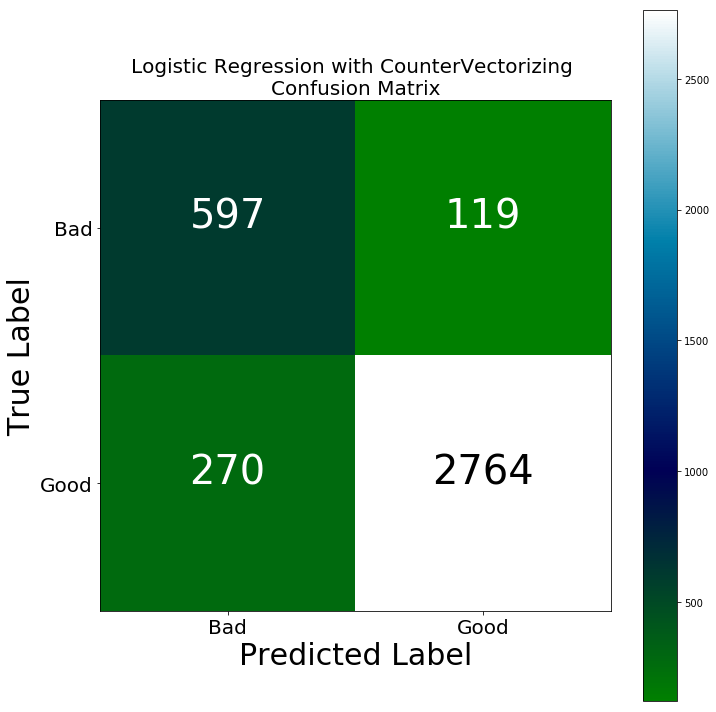

In [343]:
# Print confusion matrix for logistic regression with countvectorizer
disp_confusion_matrix(y_pred_cv_logreg, "Logistic Regression")

### 4.1.2 Random Forest with CountVectorizer¶

In [344]:
# Call the modeling function for random forest classifier with countvectorizer and print f1 score
modeling(RandomForestClassifier(n_estimators = 200, random_state = 42))

# Assign y_pred to a variable for further process
y_pred_cv_rf = y_pred

f1 score: 0.822843035346418


#### Classification Report

In [345]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_rf))

              precision    recall  f1-score   support

           0       0.97      0.26      0.41       716
           1       0.85      1.00      0.92      3034

   micro avg       0.86      0.86      0.86      3750
   macro avg       0.91      0.63      0.67      3750
weighted avg       0.87      0.86      0.82      3750



#### Confusion Matrix

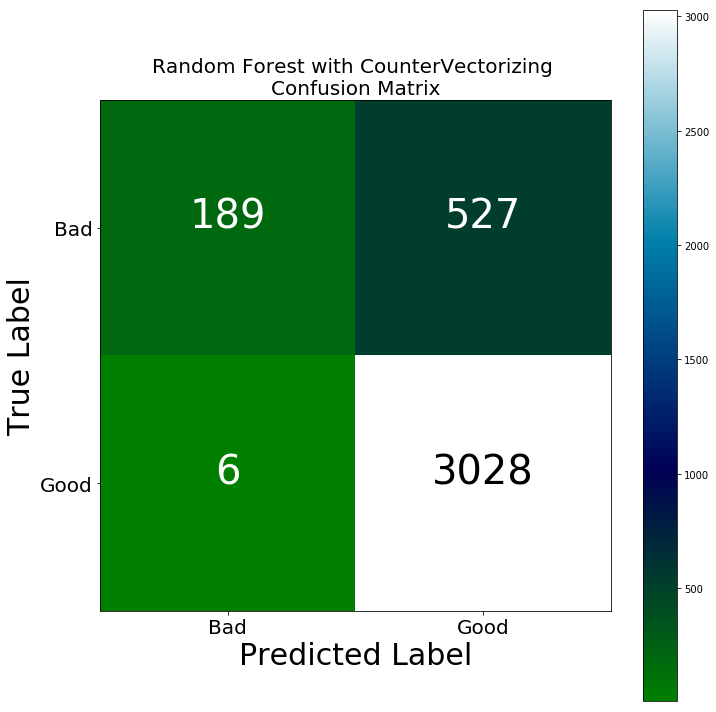

In [346]:
# Print confusion matrix for random forest classifier with countVectorizer
disp_confusion_matrix(y_pred_cv_rf, "Random Forest")

### 4.1.3 Naive Bayes with CountVectorizer

In [347]:
# Call the modeling function for naive bayes with countvectorizer and print f1 score
modeling(MultinomialNB())

# Assign y_pred to a variable for further process
y_pred_cv_nb = y_pred

f1 score: 0.8940765205962732


#### Classification Report

In [348]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_nb))

              precision    recall  f1-score   support

           0       0.79      0.64      0.71       716
           1       0.92      0.96      0.94      3034

   micro avg       0.90      0.90      0.90      3750
   macro avg       0.85      0.80      0.82      3750
weighted avg       0.89      0.90      0.89      3750



#### Confusion Matrix

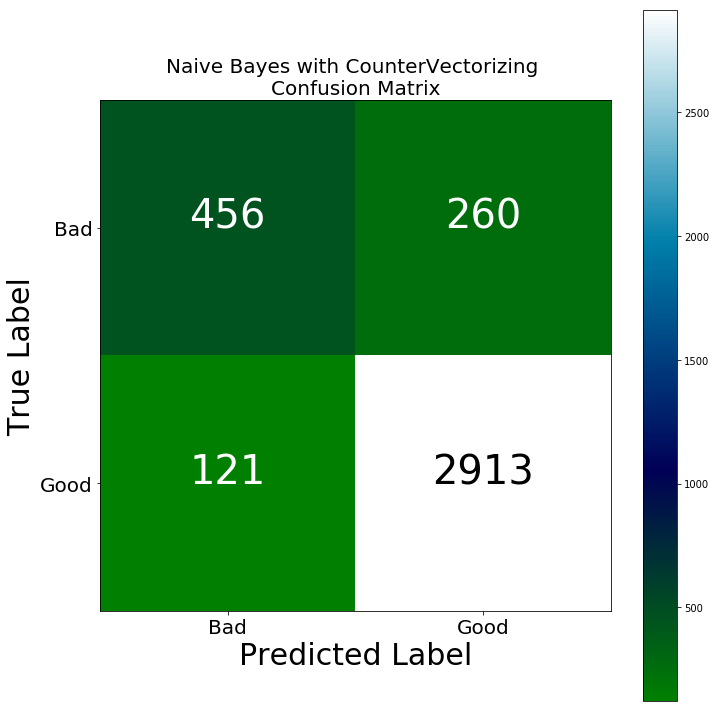

In [349]:
# Print confusion matrix for naive bayes with countVectorizer
disp_confusion_matrix(y_pred_cv_nb, "Naive Bayes")

### 4.1.4 XGBoost with CountVectorizer

In [350]:
# Call the modeling function for XGBoost with countvectorizer and print f1 score
modeling(XGBClassifier())

# Assign y_pred to a variable for further process
y_pred_cv_xgb = y_pred

f1 score: 0.8783545570035262


#### Classification Report

In [351]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_xgb))

              precision    recall  f1-score   support

           0       0.88      0.50      0.63       716
           1       0.89      0.98      0.94      3034

   micro avg       0.89      0.89      0.89      3750
   macro avg       0.89      0.74      0.79      3750
weighted avg       0.89      0.89      0.88      3750



#### Confusion Matrix

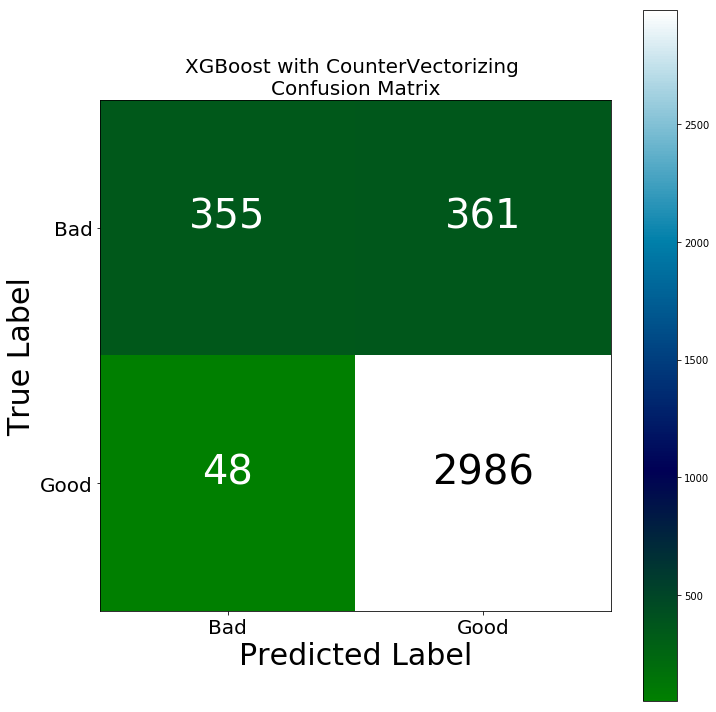

In [352]:
# Print confusion matrix for gradient boosting with countVectorizer
disp_confusion_matrix(y_pred_cv_xgb, "XGBoost")

### 4.1.5 CatBoost with CountVectorizer

In [353]:
# Call the modeling function for CatBoost with countvectorizer and print f1 score
modeling(CatBoostClassifier(iterations=100, learning_rate=0.8, 
                            depth=2, loss_function='Logloss'))

# Assign y_pred to a variable for further process
y_pred_cv_catboost = y_pred

0:	learn: 0.4149902	total: 38.8ms	remaining: 3.84s
1:	learn: 0.3882136	total: 76.4ms	remaining: 3.74s
2:	learn: 0.3665285	total: 112ms	remaining: 3.61s
3:	learn: 0.3514550	total: 148ms	remaining: 3.54s
4:	learn: 0.3317961	total: 184ms	remaining: 3.5s
5:	learn: 0.3243804	total: 222ms	remaining: 3.48s
6:	learn: 0.3192268	total: 264ms	remaining: 3.51s
7:	learn: 0.3145347	total: 301ms	remaining: 3.46s
8:	learn: 0.3107004	total: 338ms	remaining: 3.41s
9:	learn: 0.3054908	total: 374ms	remaining: 3.37s
10:	learn: 0.3021443	total: 409ms	remaining: 3.31s
11:	learn: 0.2977321	total: 445ms	remaining: 3.27s
12:	learn: 0.2938929	total: 482ms	remaining: 3.22s
13:	learn: 0.2897427	total: 516ms	remaining: 3.17s
14:	learn: 0.2866965	total: 552ms	remaining: 3.13s
15:	learn: 0.2844349	total: 587ms	remaining: 3.08s
16:	learn: 0.2821020	total: 621ms	remaining: 3.03s
17:	learn: 0.2773247	total: 654ms	remaining: 2.98s
18:	learn: 0.2747968	total: 692ms	remaining: 2.95s
19:	learn: 0.2718236	total: 726ms	remain

#### Classification Report

In [354]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_cv_catboost))

              precision    recall  f1-score   support

           0       0.82      0.59      0.69       716
           1       0.91      0.97      0.94      3034

   micro avg       0.90      0.90      0.90      3750
   macro avg       0.86      0.78      0.81      3750
weighted avg       0.89      0.90      0.89      3750



#### Confusion Matrix

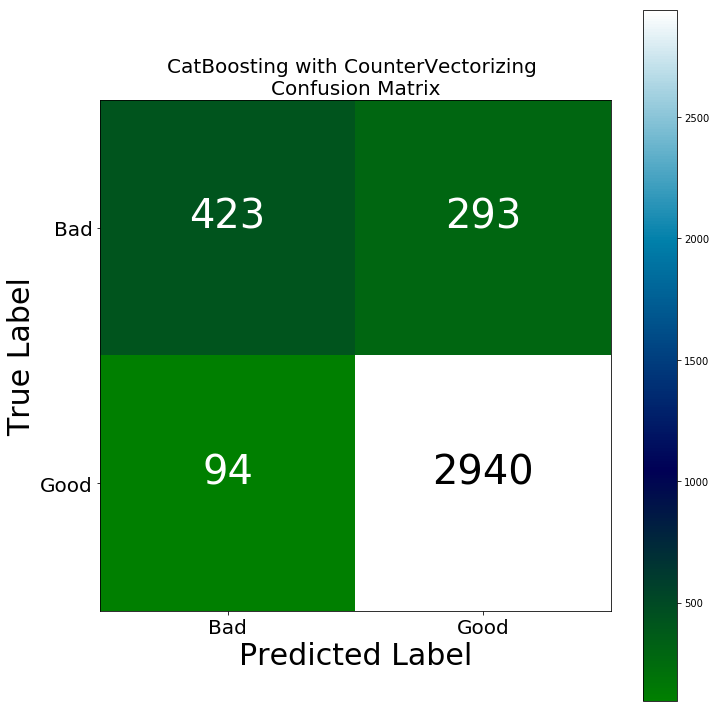

In [355]:
# Print confusion matrix for CatBoost with countVectorizer
disp_confusion_matrix(y_pred_cv_catboost, "CatBoosting")

### 4.1.6 Comparison of Models with CountVectorizer

In [356]:
# Function for converting the "classification report" results to a dataframe
def pandas_classification_report(y_true, y_pred):
    metrics_summary = precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred)

    avg = list(precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred,
            average='weighted'))

    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(
        list(metrics_summary),
        index=metrics_sum_index)

    support = class_report_df.loc['support']
    total = support.sum() 
    avg[-1] = total

    class_report_df['weighted avg'] = avg

    return class_report_df.T

# Function for adding explanatory columns and organizing all dataframe
def comparison_matrix(y_test, y_pred, label, vector):
    df = pandas_classification_report(y_test, y_pred)
    df['class']=['bad', 'good', 'average']
    df['accuracy']= metrics.accuracy_score(y_test, y_pred)
    df['model'] = label
    df['vectorizer'] = vector
    df = df[['vectorizer', 'model', 'accuracy', 'class', 'precision', 'recall', 'f1-score', 'support']]
    return df

In [357]:
#For loop for using "comparison functions" 

def comparison_table(y_preds, labels):
    
    # empty list for collecting dataframes
    frames_tv = [] 
    
    # list for y_preds
    y_preds_tv = y_preds
    
    # list for labels
    labels_tv = labels  
    
    vector_tv = 'CountVect'
    
    for y_pred, label in zip(y_preds_tv, labels_tv):
        df = comparison_matrix(y_test, y_pred, label, vector_tv)
        frames_tv.append(df)

    # concatenating all dataframes
    global df_tv
    df_tv = pd.concat(frames_tv)
    
    global df_tv2
    df_tv2 = df_tv.set_index(['vectorizer', 'model', 'accuracy', 'class'])

### Function for f1 Score Plotting

In [358]:
def f1_score_bar_plot(df, category, title):
    df = df[df['class']==category]
    x = list(df['model'])
    y = list(df['f1-score'])
    y_round = list(round(df['f1-score'],2))
    a = (list(df['f1-score'])).index(max(list(df['f1-score'])))
    z = (list(df['f1-score'])).index(min(list(df['f1-score'])))
    y_mean = round(df['f1-score'].mean(),2)
    
    plt.rcParams['figure.figsize']=[15,5]
    b_plot = plt.bar(x=x,height=y)
    b_plot[a].set_color('g')
    b_plot[z].set_color('r')
    
    for i,v in enumerate(y_round):
        plt.text(i-.15,0.018,str(v), color='black', fontsize=15, fontweight='bold')
    
    plt.axhline(y_mean,ls='--',color='k',label=y_mean)
    plt.title(title)
    plt.legend()
    
    return plt.show()

### Algorithms Comparison with CountVectorizer

In [359]:
comparison_table(y_preds = [y_pred_cv_logreg, y_pred_cv_rf, y_pred_cv_nb, y_pred_cv_xgb, y_pred_cv_catboost], 
                labels = ['LogReg', 'Random Forest', 'Naive Bayes', 'XGBoost', 'CatBoost'])

In [360]:
df_tv2

precision    recall  f1-score  \
vectorizer model         accuracy class                                    
CountVect  LogReg        0.896267 bad       0.688581  0.833799  0.754264   
                                  good      0.958724  0.911009  0.934257   
                                  average   0.907144  0.896267  0.899891   
           Random Forest 0.857867 bad       0.969231  0.263966  0.414929   
                                  good      0.851758  0.998022  0.919108   
                                  average   0.874188  0.857867  0.822843   
           Naive Bayes   0.898400 bad       0.790295  0.636872  0.705336   
                                  good      0.918059  0.960119  0.938618   
                                  average   0.893664  0.898400  0.894077   
           XGBoost       0.890933 bad       0.880893  0.495810  0.634495   
                                  good      0.892142  0.984179  0.935903   
                                  average   0.889994  0.890933  0.878355   
           CatBoost      0.896800 bad       0.818182  0.590782  0.686131   
                                  good      0.909372  0.969018  0.938248   
                                  average   0.891961  0.896800  0.890111   

                                           support  
vectorizer model         accuracy class             
CountVect  LogReg        0.896267 bad        716.0  
                                  good      3034.0  
                                  average   3750.0  
           Random Forest 0.857867 bad        716.0  
                                  good      3034.0  
                                  average   3750.0  
           Naive Bayes   0.898400 bad        716.0  
                                  good      3034.0  
                                  average   3750.0  
           XGBoost       0.890933 bad        716.0  
                                  good      3034.0  
                                  average   3750.0  
           CatBoost      0.896800 bad        716.0  
                                  good      3034.0  
                                  average   3750.0

### Average f1 Score - Models with CountVectorizer

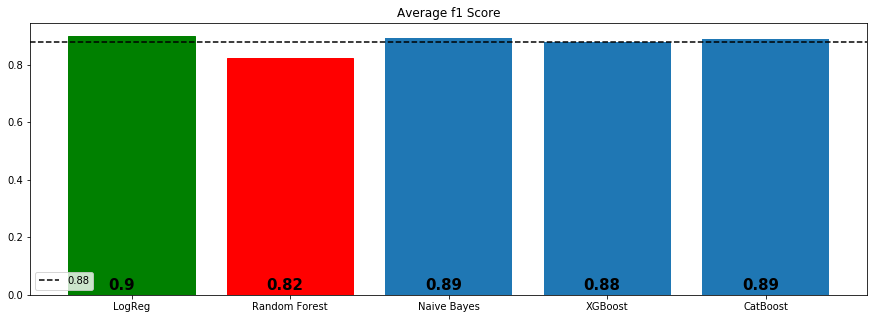

In [361]:
# Plotting f1 score with "f1_score_bar_plot" function
f1_score_bar_plot(df=df_tv, category='average', title= "Average f1 Score")

## 4.2 TF-IDF

In order to help our model focus more on meaningful words, we can use a TF-IDF score (Term Frequency, Inverse Document Frequency) on top of our Bag of Words model. TF-IDF weighs words by how rare they are in our dataset, discounting words that are too frequent and just add to the noise.

In [362]:
# Create the word vector with TF-IDF Vectorizer
tfidf_vect = TfidfVectorizer(ngram_range=(1, 1))
tfidf_vect_train = tfidf_vect.fit_transform(X_train)
tfidf_vect_train = tfidf_vect_train.toarray()
tfidf_vect_test = tfidf_vect.transform(X_test)
tfidf_vect_test = tfidf_vect_test.toarray()

### 4.2.1 Logistic Regression with TF-IDF

In [363]:

# Call the modeling function for logistic regression with TF-IDF and print f1 score
modeling(LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg', 
                            class_weight = 'balanced', C = 0.1, n_jobs = -1, random_state = 42), 
                            tfidf_vect_train, tfidf_vect_test)

# Assign y_pred to a variable for further process
y_pred_tfidf_logreg = y_pred

f1 score: 0.8758753913056039


#### Classification Report

In [364]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_tfidf_logreg))

              precision    recall  f1-score   support

           0       0.60      0.89      0.72       716
           1       0.97      0.86      0.91      3034

   micro avg       0.87      0.87      0.87      3750
   macro avg       0.79      0.88      0.82      3750
weighted avg       0.90      0.87      0.88      3750



#### Confusion Matrix

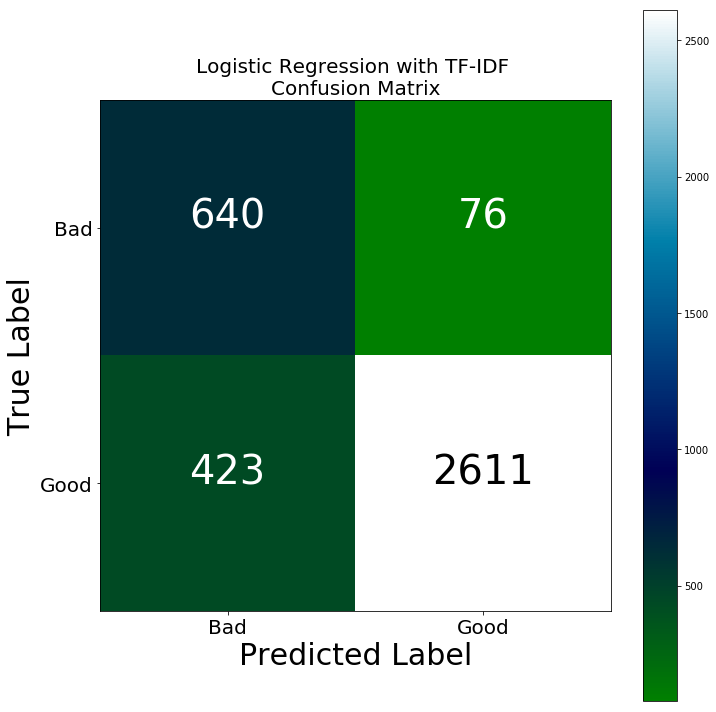

In [365]:
# Print confusion matrix for logistic regression with TF-IDF
disp_confusion_matrix(y_pred_tfidf_logreg, "Logistic Regression", "TF-IDF")

### 4.2.2 Random Forest with TF-IDF

In [366]:
# Call the modeling function for random forest classifier with TF-IDF and print f1 score
modeling(RandomForestClassifier(n_estimators = 200, random_state = 42), 
         tfidf_vect_train, tfidf_vect_test)

# Assign y_pred to a variable for further process
y_pred_tfidf_rf = y_pred

f1 score: 0.8128075872155828


#### Classification Report

In [367]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_tfidf_rf))

              precision    recall  f1-score   support

           0       0.99      0.23      0.37       716
           1       0.85      1.00      0.92      3034

   micro avg       0.85      0.85      0.85      3750
   macro avg       0.92      0.61      0.65      3750
weighted avg       0.87      0.85      0.81      3750



#### Confusion Matrix

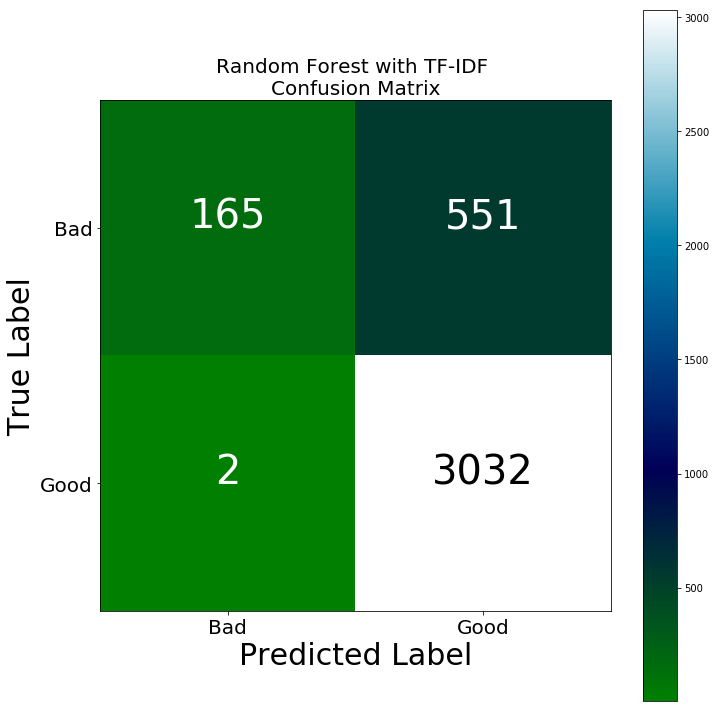

In [368]:
# Print confusion matrix for random forest classifier with TF-IDF
disp_confusion_matrix(y_pred_tfidf_rf, "Random Forest", "TF-IDF")

### 4.2.3 Naive Bayes with TF-IDF

In [369]:
# Call the modeling function for naive bayes with TF-IDF and print f1 score
modeling(MultinomialNB(), tfidf_vect_train, tfidf_vect_test)

# Assign y_pred to a variable for further process
y_pred_tfidf_nb = y_pred

f1 score: 0.7249528923440633


#### Classification Report

In [370]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_tfidf_nb))

              precision    recall  f1-score   support

           0       1.00      0.00      0.01       716
           1       0.81      1.00      0.89      3034

   micro avg       0.81      0.81      0.81      3750
   macro avg       0.90      0.50      0.45      3750
weighted avg       0.85      0.81      0.72      3750



#### Confusion Matrix

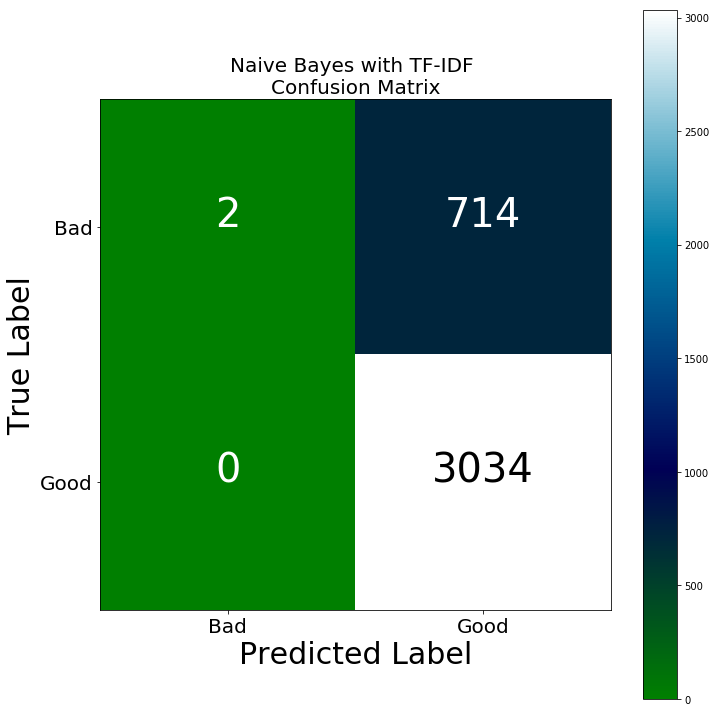

In [371]:
# Print confusion matrix for naive bayes with TF-IDF
disp_confusion_matrix(y_pred_tfidf_nb, "Naive Bayes", "TF-IDF")

### 4.2.4 XGBoost with TF-IDF

In [372]:
# Call the modeling function for XGBoost with TF-IDF and print f1 score
modeling(XGBClassifier(), tfidf_vect_train, tfidf_vect_test)

# Assign y_pred to a variable for further process
y_pred_tfidf_xgb = y_pred

f1 score: 0.8790251950947602


#### Classification Report

In [373]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_tfidf_xgb))

              precision    recall  f1-score   support

           0       0.90      0.49      0.63       716
           1       0.89      0.99      0.94      3034

   micro avg       0.89      0.89      0.89      3750
   macro avg       0.90      0.74      0.79      3750
weighted avg       0.89      0.89      0.88      3750



#### Confusion Matrix

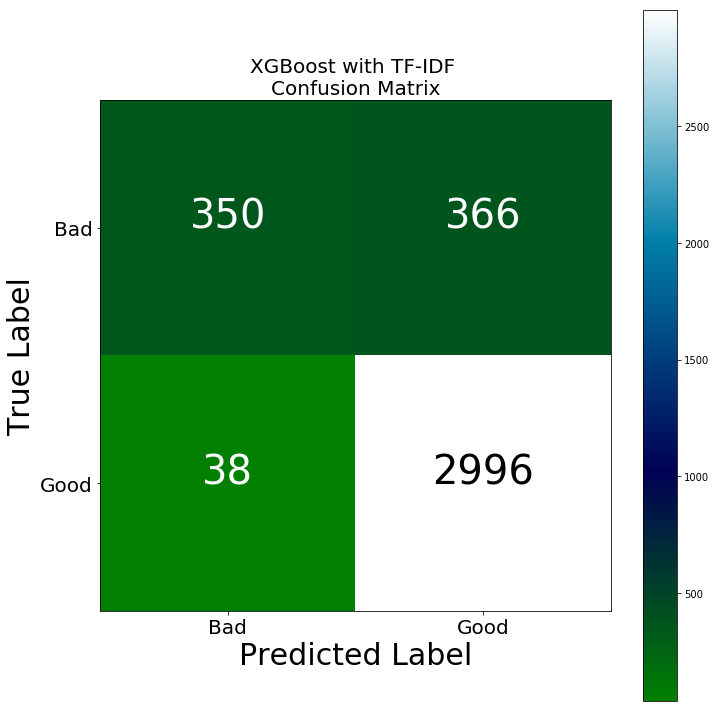

In [374]:
# Print confusion matrix for XGBoost with TF-IDF
disp_confusion_matrix(y_pred_tfidf_xgb, "XGBoost", "TF-IDF")

### 4.2.5 Catboost with TF-IDF

In [375]:
# Call the modeling function for Catboost with TF-IDF and print f1 score
modeling(CatBoostClassifier(iterations=100, learning_rate=0.8, depth=2, 
                            loss_function='Logloss'), tfidf_vect_train, tfidf_vect_test)

# Assign y_pred to a variable for further process
y_pred_tfidf_catboost = y_pred

0:	learn: 0.4383586	total: 83.2ms	remaining: 8.24s
1:	learn: 0.3981242	total: 160ms	remaining: 7.86s
2:	learn: 0.3729328	total: 211ms	remaining: 6.83s
3:	learn: 0.3576953	total: 264ms	remaining: 6.34s
4:	learn: 0.3435566	total: 318ms	remaining: 6.05s
5:	learn: 0.3351257	total: 375ms	remaining: 5.87s
6:	learn: 0.3280774	total: 428ms	remaining: 5.69s
7:	learn: 0.3162743	total: 478ms	remaining: 5.49s
8:	learn: 0.3112965	total: 530ms	remaining: 5.35s
9:	learn: 0.3056038	total: 596ms	remaining: 5.37s
10:	learn: 0.3005009	total: 669ms	remaining: 5.42s
11:	learn: 0.2972955	total: 766ms	remaining: 5.62s
12:	learn: 0.2933739	total: 861ms	remaining: 5.76s
13:	learn: 0.2865043	total: 938ms	remaining: 5.76s
14:	learn: 0.2833075	total: 1.02s	remaining: 5.76s
15:	learn: 0.2785762	total: 1.09s	remaining: 5.74s
16:	learn: 0.2773518	total: 1.16s	remaining: 5.66s
17:	learn: 0.2734539	total: 1.21s	remaining: 5.53s
18:	learn: 0.2695197	total: 1.27s	remaining: 5.42s
19:	learn: 0.2634032	total: 1.32s	remain

#### Classification Report

In [376]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_tfidf_catboost))

              precision    recall  f1-score   support

           0       0.81      0.60      0.69       716
           1       0.91      0.97      0.94      3034

   micro avg       0.90      0.90      0.90      3750
   macro avg       0.86      0.78      0.81      3750
weighted avg       0.89      0.90      0.89      3750



#### Confusion Matrix

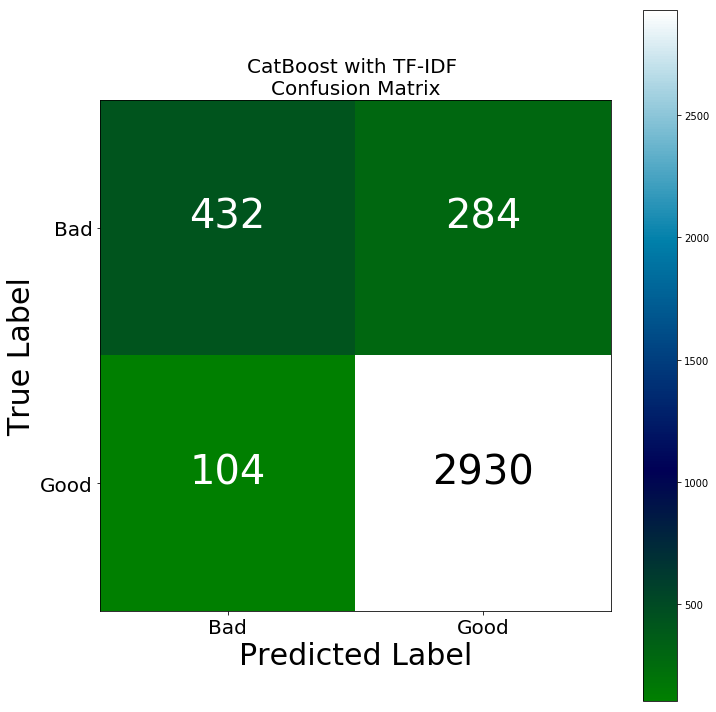

In [377]:
# Print confusion matrix for CatBoost with TF-IDF
disp_confusion_matrix(y_pred_tfidf_catboost, "CatBoost", "TF-IDF")

### 4.2.6 Comparision of Models with TF-IDF Vectorizer

In [378]:
comparison_table(y_preds = [y_pred_tfidf_logreg, y_pred_tfidf_rf, y_pred_tfidf_nb, y_pred_tfidf_xgb, y_pred_tfidf_catboost], 
                labels = ['LogReg', 'Random Forest', 'Naive Bayes', 'XGBoost', 'CatBoost'])

#### Comparison Table - TF-IDF Vectorizing

In [379]:
# Print the comparision matrix
print('\nComparision Matrix of Models with TF-IDF Vectorizer\n')
df_tv2


Comparision Matrix of Models with TF-IDF Vectorizer



precision    recall  f1-score  \
vectorizer model         accuracy class                                    
CountVect  LogReg        0.866933 bad       0.602070  0.893855  0.719505   
                                  good      0.971716  0.860580  0.912777   
                                  average   0.901138  0.866933  0.875875   
           Random Forest 0.852533 bad       0.988024  0.230447  0.373726   
                                  good      0.846218  0.999341  0.916427   
                                  average   0.873294  0.852533  0.812808   
           Naive Bayes   0.809600 bad       1.000000  0.002793  0.005571   
                                  good      0.809498  1.000000  0.894721   
                                  average   0.845872  0.809600  0.724953   
           XGBoost       0.892267 bad       0.902062  0.488827  0.634058   
                                  good      0.891136  0.987475  0.936836   
                                  average   0.893222  0.892267  0.879025   
           CatBoost      0.896533 bad       0.805970  0.603352  0.690096   
                                  good      0.911637  0.965722  0.937900   
                                  average   0.891461  0.896533  0.890586   

                                           support  
vectorizer model         accuracy class             
CountVect  LogReg        0.866933 bad        716.0  
                                  good      3034.0  
                                  average   3750.0  
           Random Forest 0.852533 bad        716.0  
                                  good      3034.0  
                                  average   3750.0  
           Naive Bayes   0.809600 bad        716.0  
                                  good      3034.0  
                                  average   3750.0  
           XGBoost       0.892267 bad        716.0  
                                  good      3034.0  
                                  average   3750.0  
           CatBoost      0.896533 bad        716.0  
                                  good      3034.0  
                                  average   3750.0

#### Average f1 score - Models with TF-IDF Vectorizer

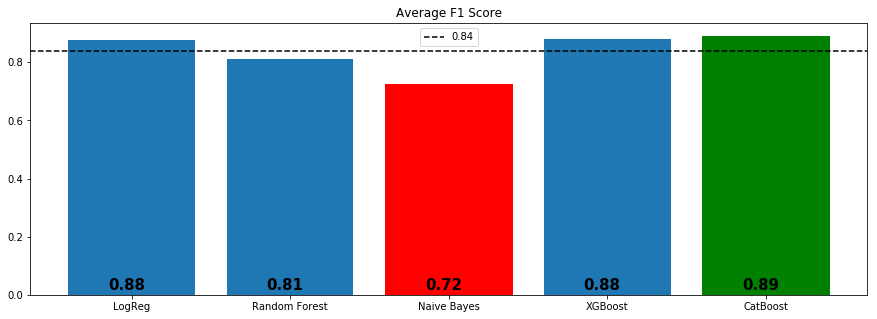

In [380]:
# Plotting f1 score with "f1_score_bar_plot" function
f1_score_bar_plot(df=df_tv, category='average', title= "Average F1 Score")

## 4.3 Hashing Vectorizer

Hash Vectorizer is designed to be as memory efficient as possible. Instead of storing the tokens as strings, the vectorizer applies the hashing trick to encode them as numerical indexes. The downside of this method is that once vectorized, the features’ names can no longer be retrieved.

In [381]:
# Create the word vector with Hash Vectorizer
hash_vect = HashingVectorizer(n_features=2000, ngram_range=(1,1), non_negative=True)
hash_vect_train = hash_vect.fit_transform(X_train)
hash_vect_train = hash_vect_train.toarray()
hash_vect_test = hash_vect.transform(X_test)
hash_vect_test = hash_vect_test.toarray()

## 4.3.1 Logistic Regression with Hash Vectorizer

In [382]:
# Call the modeling function for logistic regression with Hash Vectorizer and print f1 score
modeling(LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg', 
                            class_weight = 'balanced', C = 0.1, n_jobs = -1, random_state = 42), 
                            hash_vect_train, hash_vect_test)

# Assign y_pred to a variable for further process
y_pred_hash_logreg = y_pred

f1 score: 0.853949980795153


#### Classification Report

In [383]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_hash_logreg))

              precision    recall  f1-score   support

           0       0.56      0.86      0.68       716
           1       0.96      0.84      0.90      3034

   micro avg       0.84      0.84      0.84      3750
   macro avg       0.76      0.85      0.79      3750
weighted avg       0.89      0.84      0.85      3750



#### Confusion Matrix

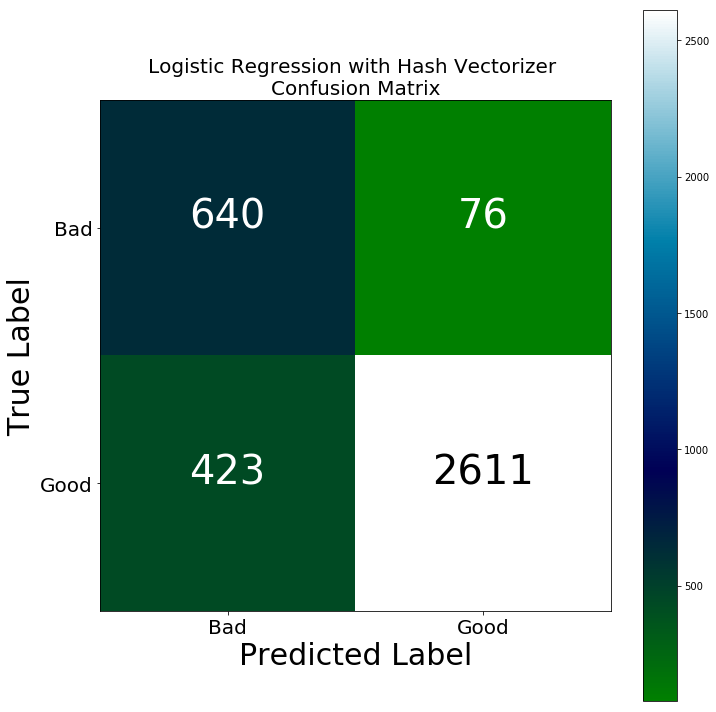

In [384]:
# Print confusion matrix for logistic regression with Hash Vectorizer
disp_confusion_matrix(y_pred_tfidf_logreg, "Logistic Regression", "Hash Vectorizer")

## 4.3.2 Random Forest with Hash Vectorizer

In [385]:
# Call the modeling function for random forest classifier with Hash Vectorizer and print f1 score
modeling(RandomForestClassifier(n_estimators = 200, random_state = 42), 
         hash_vect_train, hash_vect_test)

# Assign y_pred to a variable for further process
y_pred_hash_rf = y_pred

f1 score: 0.8436304967494852


#### Classification Report

In [386]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_hash_rf))

              precision    recall  f1-score   support

           0       0.97      0.33      0.50       716
           1       0.86      1.00      0.93      3034

   micro avg       0.87      0.87      0.87      3750
   macro avg       0.92      0.67      0.71      3750
weighted avg       0.88      0.87      0.84      3750



#### Confusion Matrix

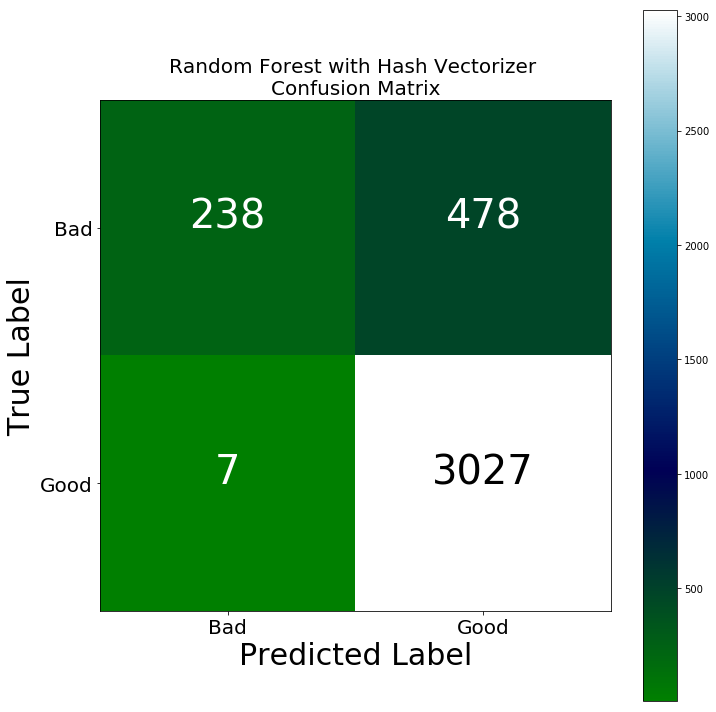

In [387]:
# Print confusion matrix for random forest classifier with Hash Vectorizer
disp_confusion_matrix(y_pred_hash_rf, "Random Forest", "Hash Vectorizer")

## 4.3.3 Naive Bayes with Hash Vectorizer

In [388]:
# Call the modeling function for naive bayes with Hash Vectorizer and print f1 score
modeling(MultinomialNB(), hash_vect_train, hash_vect_test)

# Assign y_pred to a variable for further process
y_pred_hash_nb = y_pred

f1 score: 0.7402935884948146


#### Classification Report

In [389]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_hash_nb))

              precision    recall  f1-score   support

           0       0.96      0.04      0.07       716
           1       0.81      1.00      0.90      3034

   micro avg       0.82      0.82      0.82      3750
   macro avg       0.89      0.52      0.49      3750
weighted avg       0.84      0.82      0.74      3750



#### Confusion Matrix

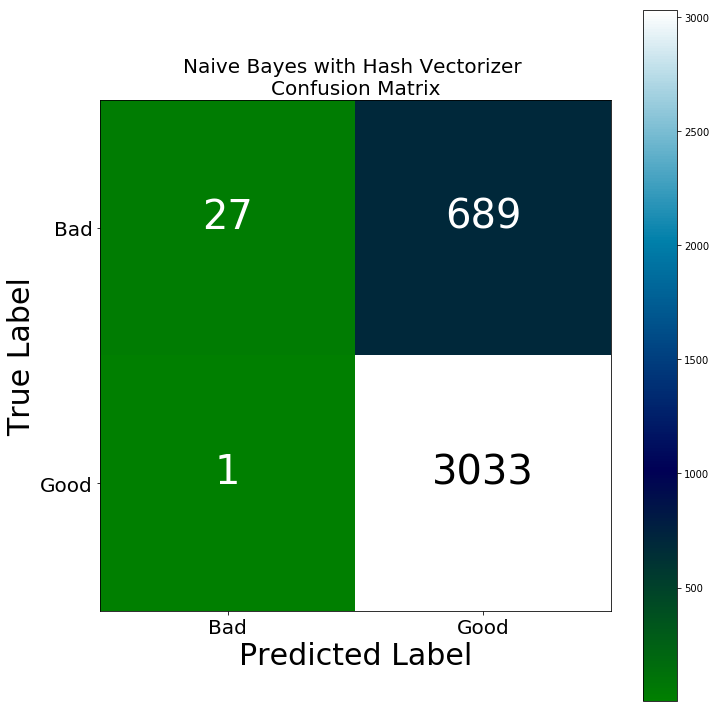

In [390]:
# Print confusion matrix for naive bayes with Hash Vectorizer
disp_confusion_matrix(y_pred_hash_nb, "Naive Bayes", "Hash Vectorizer")

## 4.3.4 XGBoost with Hash Vectorize

In [391]:
# Call the modeling function for XGBoost with Hash Vectorizer and print f1 score
modeling(XGBClassifier(), hash_vect_train, hash_vect_test)

# Assign y_pred to a variable for further process
y_pred_hash_xgb = y_pred

f1 score: 0.8751161670487743


#### Classification Report

In [392]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_hash_xgb))

              precision    recall  f1-score   support

           0       0.91      0.47      0.62       716
           1       0.89      0.99      0.94      3034

   micro avg       0.89      0.89      0.89      3750
   macro avg       0.90      0.73      0.78      3750
weighted avg       0.89      0.89      0.88      3750



#### Confusion Matrix

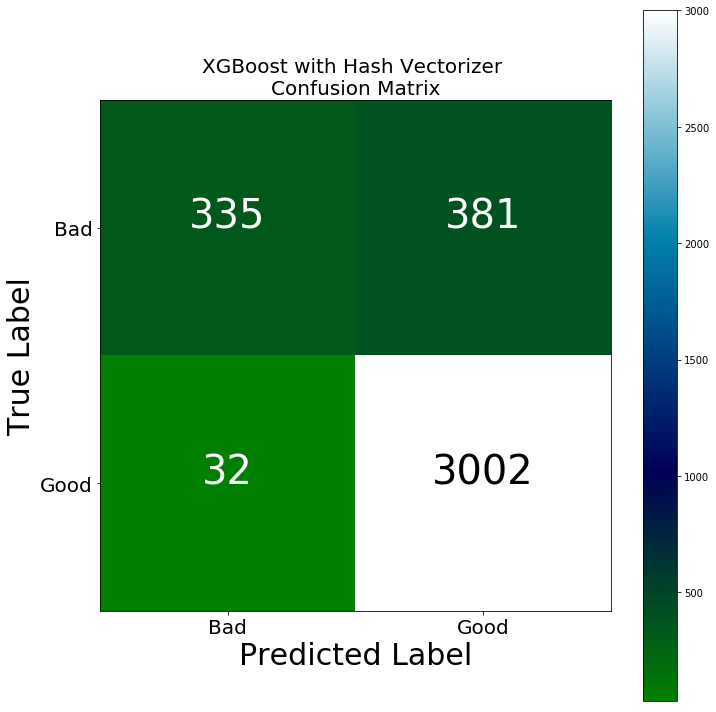

In [393]:
# Print confusion matrix for XGBoost with Hash Vectorizer
disp_confusion_matrix(y_pred_hash_xgb, "XGBoost", "Hash Vectorizer")

## 4.3.5 CatBoost with Hash Vectorizer

In [394]:
# Call the modeling function for Catboost with Hash Vectorizer and print f1 score
modeling(CatBoostClassifier(iterations=100, learning_rate=0.8, depth=2, 
                            loss_function='Logloss'), hash_vect_train, hash_vect_test)

# Assign y_pred to a variable for further process
y_pred_hash_catboost = y_pred

0:	learn: 0.4436666	total: 38.4ms	remaining: 3.8s
1:	learn: 0.4054524	total: 65.4ms	remaining: 3.2s
2:	learn: 0.3877559	total: 90.2ms	remaining: 2.92s
3:	learn: 0.3692404	total: 119ms	remaining: 2.85s
4:	learn: 0.3542018	total: 144ms	remaining: 2.73s
5:	learn: 0.3464598	total: 170ms	remaining: 2.66s
6:	learn: 0.3390359	total: 205ms	remaining: 2.73s
7:	learn: 0.3306293	total: 235ms	remaining: 2.7s
8:	learn: 0.3247772	total: 265ms	remaining: 2.68s
9:	learn: 0.3175526	total: 292ms	remaining: 2.62s
10:	learn: 0.3118713	total: 325ms	remaining: 2.63s
11:	learn: 0.3084001	total: 364ms	remaining: 2.67s
12:	learn: 0.3043861	total: 392ms	remaining: 2.62s
13:	learn: 0.2986331	total: 420ms	remaining: 2.58s
14:	learn: 0.2944729	total: 448ms	remaining: 2.54s
15:	learn: 0.2924550	total: 478ms	remaining: 2.51s
16:	learn: 0.2877954	total: 508ms	remaining: 2.48s
17:	learn: 0.2840579	total: 537ms	remaining: 2.45s
18:	learn: 0.2786848	total: 570ms	remaining: 2.43s
19:	learn: 0.2767799	total: 600ms	remaini

#### Classification Report

In [395]:
# Compute and print the classification report
print(classification_report(y_test, y_pred_hash_catboost))

              precision    recall  f1-score   support

           0       0.81      0.58      0.68       716
           1       0.91      0.97      0.94      3034

   micro avg       0.89      0.89      0.89      3750
   macro avg       0.86      0.77      0.81      3750
weighted avg       0.89      0.89      0.89      3750



#### Confusion Matrix

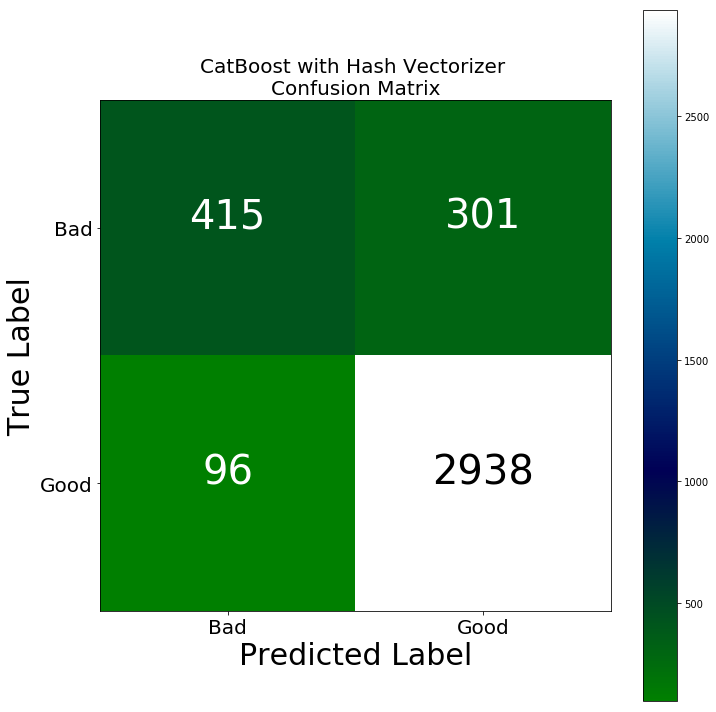

In [396]:
# Print confusion matrix for CatBoost with Hash Vectorizer
disp_confusion_matrix(y_pred_hash_catboost, "CatBoost", "Hash Vectorizer")

## 4.3.6 Comparison of Models with Hash Vectorizer

In [397]:
comparison_table(y_preds = [y_pred_hash_logreg, y_pred_hash_rf, y_pred_hash_nb, y_pred_hash_xgb, y_pred_hash_catboost], 
                labels = ['LogReg', 'Random Forest', 'Naive Bayes', 'XGBoost', 'CatBoost'])

#### Comparison Table

In [398]:
# Print the comparision matrix
print('\nComparision Matrix of Models with Hash Vectorizer\n')
df_tv2


Comparision Matrix of Models with Hash Vectorizer



precision    recall  f1-score  \
vectorizer model         accuracy class                                    
CountVect  LogReg        0.842400 bad       0.556256  0.863128  0.676519   
                                  good      0.962865  0.837508  0.895822   
                                  average   0.885229  0.842400  0.853950   
           Random Forest 0.870667 bad       0.971429  0.332402  0.495317   
                                  good      0.863623  0.997693  0.925830   
                                  average   0.884207  0.870667  0.843630   
           Naive Bayes   0.816000 bad       0.964286  0.037709  0.072581   
                                  good      0.814884  0.999670  0.897869   
                                  average   0.843410  0.816000  0.740294   
           XGBoost       0.889867 bad       0.912807  0.467877  0.618652   
                                  good      0.887378  0.989453  0.935640   
                                  average   0.892233  0.889867  0.875116   
           CatBoost      0.894133 bad       0.812133  0.579609  0.676447   
                                  good      0.907070  0.968359  0.936713   
                                  average   0.888943  0.894133  0.887019   

                                           support  
vectorizer model         accuracy class             
CountVect  LogReg        0.842400 bad        716.0  
                                  good      3034.0  
                                  average   3750.0  
           Random Forest 0.870667 bad        716.0  
                                  good      3034.0  
                                  average   3750.0  
           Naive Bayes   0.816000 bad        716.0  
                                  good      3034.0  
                                  average   3750.0  
           XGBoost       0.889867 bad        716.0  
                                  good      3034.0  
                                  average   3750.0  
           CatBoost      0.894133 bad        716.0  
                                  good      3034.0  
                                  average   3750.0

#### Average f1 score - Hash Vectorizer

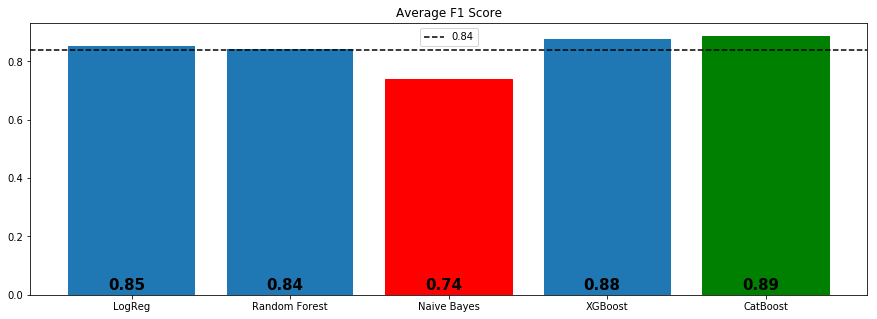

In [399]:
# Plotting f1 score with "f1_score_bar_plot" function
f1_score_bar_plot(df=df_tv, category='average', title= "Average F1 Score")